In [1]:
import deco
import deco_mix
import deco_helper
import numpy
import untangle
import copy
import matplotlib

# This line configures matplotlib to show figures embedded in the notebook, 
# instead of opening a new window for each figure. More about that later. 
# If you are using an old version of IPython, try using '%pylab inline' instead.
%matplotlib inline

In [2]:
# Globals
settings = deco.deco_settings(
    last_stop = 9,
    gf_low = 0.1,
    gf_high = 0.90)
precision = numpy.float32
profile_time_factor = 1
sac_bottom = 18
sac_deco = 15
xml_file = "profiles/gourneyras_plan_2.uddf"

In [3]:
doc = untangle.parse(xml_file)

In [4]:
mix_ctx = deco_mix.deco_mix_ctx()

gasmixes = dict()

imix = 0
for mix in doc.uddf.gasdefinitions.mix:
    try:
        switchdepth = int(mix.switchdepth.cdata)
    except:
        switchdepth = 0
    gasmixes.update({ mix['id']: {
        'imix': imix,
        'f_he': float(mix.he.cdata),
        'f_o2': float(mix.o2.cdata),
        'f_n2': 1 - float(mix.o2.cdata) - float(mix.he.cdata) }})
    mix_ctx.set_mix(
        imix,
        deco_mix.deco_mix(f_o2 = float(mix.o2.cdata),
        f_he = float(mix.he.cdata),
        switch_depth = switchdepth,
        enabled = True))
    imix += 1

#print(gasmixes)
#print(mix_ctx)

In [5]:
# Initialize decompression context
try:
    p_surface_in = float(doc.uddf.profiledata.repetitiongroup.dive.informationbeforedive.surfacepressure.cdata) / 100000
except:
    p_surface_in = 1.0

deco_ctx = deco.deco_zhl16b(
    settings = settings,
    mix_ctx = mix_ctx,
    p_surface = p_surface_in,
    salinity = 1.0)

#print(deco_ctx)

In [6]:
dive_profile = deco_helper.profile(
        runtime = 0,
        ctx = deco_ctx,
        maxentries = len(doc.uddf.profiledata.repetitiongroup.dive.samples.waypoint))

# Read profile
runtime = 0
depth = 0
lastruntime = 0
lastdepth = 0
for waypoint in doc.uddf.profiledata.repetitiongroup.dive.samples.waypoint:
    try:
        activemix = waypoint.switchmix['ref']
        # eventually switch mix
        dive_profile.ctx.mix_ctx.set_active_mix(gasmixes[activemix]['imix'])
        #print("switch mix: %s" % (dive_profile.ctx.mix_ctx.get_mix(dive_profile.ctx.mix_ctx.get_active_mix())))
    except:
        pass
    
    runtime = float(waypoint.divetime.cdata) / 60.0 * profile_time_factor
    depth = float(waypoint.depth.cdata)

    #print("runtime: %.1f min. depth: %.1f m lastdepth %.1f m" % (runtime, depth, lastdepth))
    
    if (depth != 0 and runtime - lastruntime > 0):
        #%lprun -s -m deco dive_profile.update(time = runtime - lastruntime, depth_begin = lastdepth, depth_end = depth, sac = sac_bottom)
        dive_profile.update(
            time = runtime - lastruntime,
            depth_begin = lastdepth,
            depth_end = depth,
            sac = sac_bottom)
                
    lastruntime = runtime
    lastdepth = depth

# Strip data array to number of actually valid records
dive_profile.strip()

#print(dive_profile.di)
#print(dive_profile.ctx.mix_ctx)

In [7]:
deco_profile = deco_helper.profile(
        runtime = dive_profile.data[len(dive_profile.data) - 1]['time'],
        ctx = dive_profile.ctx,
        maxentries = len(dive_profile.di.stops) + 1)

depth = dive_profile.data[len(dive_profile.data) - 1]['depth']

if (dive_profile.di.nostop_time == 0):
    # simulate calculated decoplan
    
    # if we are currently deeper, simulate ascent to first stop.
    if (depth != dive_profile.di.stops[0]['depth']):
        deco_profile.update(
            time = abs(depth - dive_profile.di.stops[0]['depth']) / deco_profile.ctx.settings.ascent_rate,
            depth_begin = depth,
            depth_end = dive_profile.di.stops[0]['depth'],
            sac = sac_bottom)
    
    for istop in range(0, len(dive_profile.di.stops)):
        if (dive_profile.di.stops[istop]['depth'] == 0 and dive_profile.di.stops[istop + 1]['depth'] == 0):
            break
        
        # eventually switch mix
        deco_profile.ctx.mix_ctx.set_active_mix(dive_profile.di.stops[istop]['mix'])
        
        # simulate stop
        deco_profile.update(
            time = dive_profile.di.stops[istop]['time'],
            depth_begin = dive_profile.di.stops[istop]['depth'],
            depth_end = dive_profile.di.stops[istop]['depth'],
            sac = sac_deco)
        
        # simulate ascent to next stop (which might be the surface as well)
        deco_profile.update(
            time = (dive_profile.di.stops[istop]['depth'] - dive_profile.di.stops[istop + 1]['depth']) / deco_profile.ctx.settings.ascent_rate,
            depth_begin = dive_profile.di.stops[istop]['depth'],
            depth_end = dive_profile.di.stops[istop + 1]['depth'],
            sac = sac_deco)
        
        #print("runtime: %.1f depth: %f mix %s\n" %
        #      (deco_profile.runtime,
        #       dive_profile.di.stops[istop]['depth'],
        #       deco_profile.ctx.mix_ctx.get_mix(deco_profile.ctx.mix_ctx.get_active_mix())))    
else:
    pass

# Strip data array to number of actually valid records
deco_profile.strip()

#print(deco_profile.ctx.mix_ctx)

/home/vke/development/deco/deco.py:202: RuntimeWarning: divide by zero encountered in true_divide
  return ((self.p_tissues_n2 + self.p_tissues_he - self.a * gf) / (gf / self.b - gf + 1)).max()
/home/vke/development/deco/deco.py:213: RuntimeWarning: divide by zero encountered in true_divide
  gf = ((self.p_tissues_n2 + self.p_tissues_he - p_amb) / ((p_amb / self.b + self.a) - p_amb)).max()


In [8]:
#data = numpy.append(dive_profile.data, deco_profile.data)
data = dive_profile.data

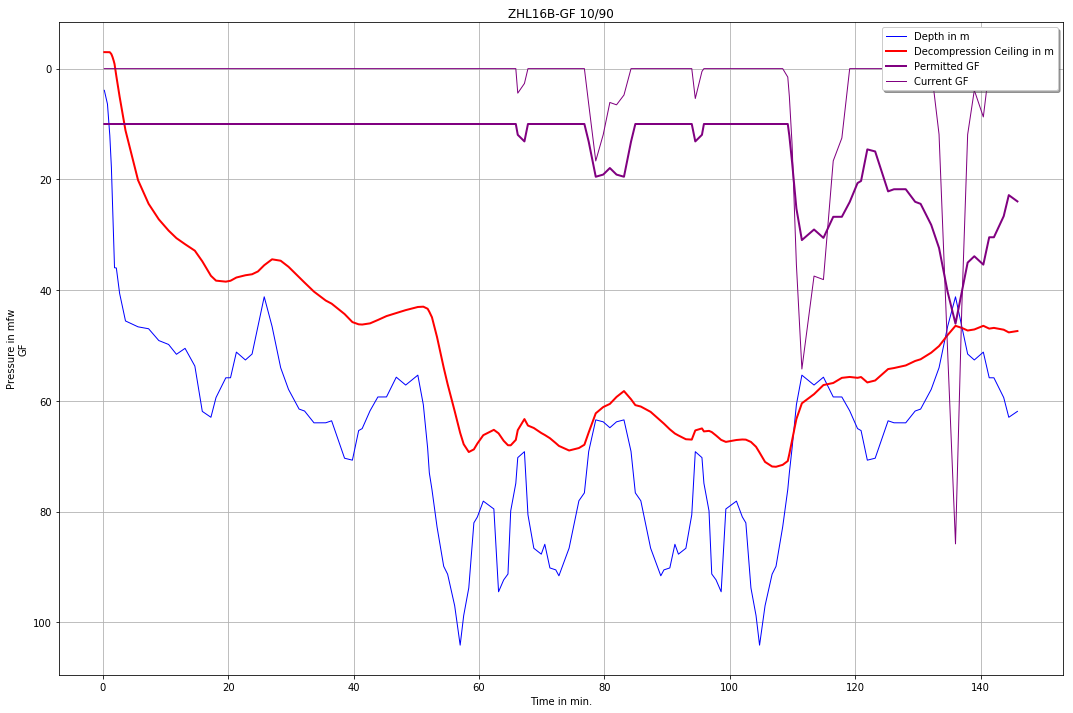

In [9]:
fig, ax = matplotlib.pyplot.subplots(figsize = (18, 12))

matplotlib.pyplot.title(
    'ZHL16B-GF {:d}/{:d}'.format(int(deco_ctx.settings.gf_low * 100), int(deco_ctx.settings.gf_high * 100)))

matplotlib.pyplot.xlabel('Time in min.')

matplotlib.pyplot.ylabel('Pressure in mfw\nGF')

ax.plot(
    data['time'],
    data['depth'],
    label = 'Depth in m',
    color = 'Blue',
    lw = 1)

#ax.set_color_cycle([matplotlib.pyplot.cm.Oranges_r(i) for i in numpy.linspace(0, 0.8, 16)])
#ax.plot(
#    data['time'],
#    data['p_tissues_n2'] * 10,
#    lw = 0.3)

#ax.set_color_cycle([matplotlib.pyplot.cm.Greens_r(i) for i in numpy.linspace(0, 0.8, 16)])
#ax.plot(
#    data['time'],
#    data['p_tissues_he'] * 10,
#    lw = 0.3)

ax.plot(
    data['time'],
    data['p_ceiling'] * 10 - 10,
    label = 'Decompression Ceiling in m',
    color = 'Red',
    lw = 2)

ax.plot(
    data['time'],
    data['gf_allowed'] * 100,
    label = 'Permitted GF',
    color = 'Purple',
    lw = 2)

ax.plot(
    data['time'],
    data['gf_current'] * 100,
    label = 'Current GF',
    color = 'Purple',
    lw = 1)

legend = ax.legend(loc = 'upper right', shadow = True)

ax.grid()
ax.invert_yaxis()


In [10]:
print("*************** SETTINGS ******************")
print(settings)

print("*************** DIVEPROFILE ***************")
print("Speed: %u m/min." % (20 / profile_time_factor))
print(dive_profile.ctx.mix_ctx)

print("*************** DECOPROFILE ***************")
print(dive_profile.di)
print(deco_profile.ctx.mix_ctx)

*************** SETTINGS ******************
gf: 10/90
nofly_pressure: 0.600000
ascent_rate: 10
stop_size: 3
last_stop: 9

*************** DIVEPROFILE ***************
Speed: 20 m/min.
Mix 0: AIR @ 0 m 0 l
Mix 1: NX100 @ 9 m 0 l
Mix 2: TX50/25 @ 21 m 0 l
Mix 3: TX35/35 @ 36 m 59 l
Mix 4: TX20/40 @ 57 m 0 l
Mix 5: TX16/60 @ 0 m 10372 l
Mix 6: TX10/70 @ 0 m 9564 l
Mix 7: AIR @ 0 m 0 l
Mix 8: AIR @ 0 m 0 l
Mix 9: AIR @ 0 m 0 l
Mix 10: AIR @ 0 m 0 l
Mix 11: AIR @ 0 m 0 l

*************** DECOPROFILE ***************
TX20/40 @ 51 m for 1 min.
TX20/40 @ 48 m for 1 min.
TX20/40 @ 45 m for 5 min.
TX20/40 @ 42 m for 6 min.
TX20/40 @ 39 m for 9 min.
TX35/35 @ 36 m for 8 min.
TX35/35 @ 33 m for 10 min.
TX35/35 @ 30 m for 13 min.
TX35/35 @ 27 m for 15 min.
TX35/35 @ 24 m for 21 min.
TX50/25 @ 21 m for 21 min.
TX50/25 @ 18 m for 26 min.
TX50/25 @ 15 m for 38 min.
TX50/25 @ 12 m for 51 min.
NX100 @ 9 m for 228 min.
Total deco time: 455 min.

Mix 0: AIR @ 0 m 0 l
Mix 1: NX100 @ 9 m 6454 l
Mix 2: TX50/25